# Capstone Project - The Battle of Neighborhoods (Week-2)
### Applied Data Science Capstone by IBM/Coursera
#### By: Made Putra

## Table of Contents
* [Introduction: Background and Business Problem](#introduction)
* [Data](#data)
* [Analysis and Methodology](#analysis)
* [Result](#result)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Bali is one of the most tourist dense destination in Indonesia. Each year, Bali airport acomodate more than 6.3 milion foreign tourist comming in to the island. This makes bali one of the most potential market for a business that rely on tourism for example culinary.  

In this capstone project, we will try to discover an optimal location for a Restaurant. This project will be targeted to stakeholder interested in opening a **resraurant** in **Bali**, Indonesia.

Since there are lots of restaurants in Bali we will try to accomodate and detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no restaurants in particular**. We would also prefer locations **as close to the beach as possible**, assuming that first two conditions are met.

The data science approach will be used in oprder to generate some most promising neighboorhoods based on the criteria that we analyzed.  

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

A description of the data: the data used to solve this problem is geolocation data collected from FourSquare. Adequate explanation and discussion, with examples, of the data is the following. Data is a single dataframe, containing at least a location of the restaurant. Explanation of the location data is a standard tuple (lat, lng), where lat stands for latitude and lng for longitude. Some other metadata like name, postal code and so on is also collected, but let us discuss that they are not absolutely necessary for the analysis.

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to **restaurants** in the neighborhood, if any,
* distance of neighborhood from the beach.
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

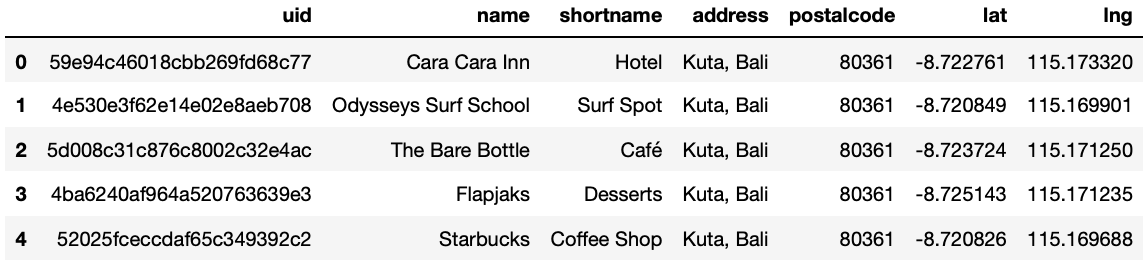

In [1]:
from IPython.display import Image
Image(filename='table1.png', width=800) 

# Analysis and Methodology <a name="analysis"></a>

Data will be used in the following way: by knowing the locations of already existing restaurant, it's possible to apply unsupervised learning heat map technique to determine the area of influence of the existing restaurant, and start up new restaurant which is not in the area of influence.

In [2]:
import requests
import pandas as pd

CLIENT_ID = 'W2A2DWDTAEPECPBIFJH5EBG2DXRU0GU3KF5NVDRBFUNVOYVK'
CLIENT_SECRET = '4HSJKLWT4SBVHQTSFSXGFIAKGQKUZNRABUXO01QUR5LKQCVB'
request_parameters = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": '20180605',
    "section": "restaurant",
    "near": "Kuta, Bali",
    "radius": 1000,
    "limit": 50}

data = requests.get("https://api.foursquare.com/v2/venues/explore", params=request_parameters)

The data contains useful information such as geocode, and details of the venue that is being retrieved. Let's display the keys of the .json file.

In [3]:
d = data.json()["response"]
d.keys()

dict_keys(['suggestedFilters', 'geocode', 'headerLocation', 'headerFullLocation', 'headerLocationGranularity', 'totalResults', 'suggestedBounds', 'groups'])

In [4]:
d["headerLocationGranularity"], d["headerLocation"], d["headerFullLocation"]

('city', 'Kuta', 'Kuta')

In [5]:
d["suggestedBounds"], d["totalResults"]

({'ne': {'lat': -8.71574608297111, 'lng': 115.17778779915754},
  'sw': {'lat': -8.730303507786049, 'lng': 115.16845879545478}},
 139)

In [6]:
d["geocode"]

{'what': '',
 'where': 'kuta bali',
 'center': {'lat': -8.72332, 'lng': 115.17234},
 'displayString': 'Kuta, Bali, Indonesia',
 'cc': 'ID',
 'geometry': {'bounds': {'ne': {'lat': -8.648911039880005,
    'lng': 115.1971435550001},
   'sw': {'lat': -8.769724598149992, 'lng': 115.11997559216941}}},
 'slug': 'kuta-indonesia',
 'longId': '72057594039566938'}

In [7]:
d["groups"][0].keys()

dict_keys(['type', 'name', 'items'])

In [8]:
d["groups"][0]["type"], d["groups"][0]["name"]

('Recommended Places', 'recommended')

In [9]:
items = d["groups"][0]["items"]
print("number of items: %i" % len(items))
items[0]

number of items: 50


{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '59e94c46018cbb269fd68c77',
  'name': 'Cara Cara Inn',
  'location': {'address': 'Gang Khayangan Suci (masuk gang fave Hotel/Zia)',
   'lat': -8.722761,
   'lng': 115.17332,
   'labeledLatLngs': [{'label': 'display',
     'lat': -8.722761,
     'lng': 115.17332}],
   'postalCode': '80361',
   'cc': 'ID',
   'city': 'Badung',
   'state': 'Bali',
   'country': 'Indonesia',
   'formattedAddress': ['Gang Khayangan Suci (masuk gang fave Hotel/Zia)',
    'Badung',
    'Bali 80361',
    'Indonesia']},
  'categories': [{'id': '4bf58dd8d48988d1fa931735',
    'name': 'Hotel',
    'pluralName': 'Hotels',
    'shortName': 'Hotel',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-59e94c46018cbb269fd68c77-

We can use `for` loop in order to display the information contained in json file into dataframe.

In [13]:
df_raw = []
for item in items:
    venue = item["venue"]
    categories, uid, name, location = venue["categories"], venue["id"], venue["name"], venue["location"]
    assert len(categories) == 1
    shortname = categories[0]["shortName"]
    if not "postalCode" in location:
        continue
    postalcode = location["postalCode"]
    lat = location["lat"]
    lng = location["lng"]
    datarow = (uid, name, shortname, address, postalcode, lat, lng)
    df_raw.append(datarow)
df = pd.DataFrame(df_raw, columns=["uid", "name", "shortname", "address", "postalcode", "lat", "lng"])
print("found %i restaurant" % len(df))
df.head()

found 31 restaurant


,uid,name,shortname,address,postalcode,lat,lng
0,59e94c46018cbb269fd68c77,Cara Cara Inn,Hotel,Gang Khayangan Suci (masuk gang fave Hotel/Zia),80361,-8.722761,115.173320
1,4e530e3f62e14e02e8aeb708,Odysseys Surf School,Surf Spot,Gang Khayangan Suci (masuk gang fave Hotel/Zia),80361,-8.720849,115.169901
2,5d008c31c876c8002c32e4ac,The Bare Bottle,Café,Gang Khayangan Suci (masuk gang fave Hotel/Zia),80361,-8.723724,115.171250
3,4ba6240af964a520763639e3,Flapjaks,Desserts,Gang Khayangan Suci (masuk gang fave Hotel/Zia),80361,-8.725143,115.171235
4,52025fceccdaf65c349392c2,Starbucks,Coffee Shop,Gang Khayangan Suci (masuk gang fave Hotel/Zia),80361,-8.720826,115.169688


In [16]:
import folium
from folium import plugins

map_bali = folium.Map(location=[lat, lng], zoom_start=14)
def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["name"], parse_html=True)
        folium.CircleMarker(
            [row["lat"], row["lng"]],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_bali)

add_markers(df)
hm_data = df[["lat", "lng"]].to_numpy().tolist()
map_bali.add_child(plugins.HeatMap(hm_data))

map_bali

# Result <a name="result"></a>

Based on the heatmap shown above, one best possible spot is at the city center accross Tegal Wangi street.

In [17]:
kuta_center = d['geocode']['center']
lat = kuta_center['lat']
lng = kuta_center['lng']
map_bali = folium.Map(location=[lat, lng], zoom_start=14)
add_markers(df)
folium.CircleMarker(
    [lat, lng],
    radius=15,
    popup="Our Restaurant!",
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_bali)
map_bali.add_child(plugins.HeatMap(hm_data))
map_bali

# Discussion <a name="discussion"></a>

The optimal location for a new coffee shop in the center of Kuta region was estimated based on the data gathered from Foursquare API. The recomendation is made based on the geocode data provided in the json data. The result shwos that the city center which described by the geocode is the most appropriate place for the new restaurant. the condition which stated on the `data` section is sattisfied where the new restaurant will be located relatively near to the beach and not too close from the existing restaurant. Since the conditions is sattisfied, it is recomended to open the new retaurant at the pointed location. 

# Conclusion <a name="conclusion"></a>

The Foursquare API provided a very comprehensive explanatory data of the studied neighborhood. The writter is able to locate surrounding and use the geodata as the reference point to open a new restaurant. Due to limited amount of free resources, a further study on the exact coordinate distance to other restaurant needs to be studied using a location locator such as Google API.  